In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [2]:
# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 获取数据

In [3]:
np.random.seed(42)
# 读取数据并处理数据
path = "Z:\data\BTCUSDT\BTCUSDT-1h"
filelist = os.listdir(path)
filelist.sort()
df = pd.DataFrame()
for i in tqdm(filelist[-300:]):
    df0 = pd.read_csv(os.path.join(path, i))
    df = pd.concat([df, df0])
df1 = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]
df1.columns = ['t', 'o', 'h', 'l', 'c', 'v']
df1 = df1.dropna()
df1

100%|██████████| 300/300 [00:06<00:00, 43.92it/s]


,t,o,h,l,c,v
0,1670976000000,17777.1,17833.9,17749.5,17817.8,10803.908
1,1670979600000,17817.8,17844.9,17772.3,17781.4,6999.399
2,1670983200000,17781.4,17815.3,17753.1,17795.1,5767.537
3,1670986800000,17795.1,17839.6,17782.4,17782.4,7150.765
4,1670990400000,17782.4,17790.5,17752.1,17772.1,5255.493
...,...,...,...,...,...,...
19,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886
20,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344
21,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588
22,1696888800000,27607.4,27627.0,27562.0,27575.9,3771.446


In [4]:
# 特征工程
def create_features(df):
    """
    创建用于预测的特征

    参数:
    df (pandas.DataFrame): 包含股票数据的DataFrame

    返回:
    pandas.DataFrame: 包含特征的DataFrame
    """
    df_feat = df.copy()

    # 创建滞后特征
    for i in range(1, 6):  # 1到5天的滞后
        df_feat[f'lag_{i}'] = df_feat['c'].shift(i)

    # 创建移动平均特征
    df_feat['MA_5'] = df_feat['c'].rolling(window=5).mean()
    df_feat['MA_10'] = df_feat['c'].rolling(window=10).mean()
    df_feat['MA_20'] = df_feat['c'].rolling(window=20).mean()

    # 创建波动率特征
    df_feat['Volatility_5'] = df_feat['c'].rolling(window=5).std()
    df_feat['Volatility_10'] = df_feat['c'].rolling(window=10).std()

    # 创建涨跌特征
    df_feat['Return'] = df_feat['c'].pct_change()
    df_feat['Return_prev'] = df_feat['Return'].shift(1)
    df_feat['Return_prev_2'] = df_feat['Return'].shift(2)

    # 创建价格变动特征
    df_feat['Price_change'] = df_feat['c'] - df_feat['o']
    df_feat['High_low'] = df_feat['h'] - df_feat['l']

    # RSI指标
    delta = df['c'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD指标
    df['ema_12'] = df['c'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['c'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # 删除包含NaN的行
    df_feat = df_feat.dropna()
    df_feat = df_feat.reset_index()

    return df_feat

In [5]:
df2 = create_features(df1)
df2

,index,t,o,h,l,c,v,lag_1,lag_2,lag_3,...,MA_5,MA_10,MA_20,Volatility_5,Volatility_10,Return,Return_prev,Return_prev_2,Price_change,High_low
0,19,1671044400000,18215.3,18400.0,17704.3,17789.5,145336.062,18215.0,18089.3,18096.9,...,18049.10,17975.20,17887.010,157.200779,144.937948,-0.023360,0.006949,-0.000420,-425.8,695.7
1,20,1671048000000,17789.5,17944.4,17659.4,17762.1,63340.245,17789.5,18215.0,18089.3,...,17990.56,17968.71,17884.225,202.515550,153.510857,-0.001540,-0.023360,0.006949,-27.4,285.0
2,21,1671051600000,17762.0,17845.6,17761.6,17827.9,14663.082,17762.1,17789.5,18215.0,...,17936.76,17969.12,17886.550,202.933531,153.085712,0.003705,-0.001540,-0.023360,65.9,84.0
3,22,1671055200000,17828.1,17876.6,17790.1,17829.7,10964.469,17827.9,17762.1,17789.5,...,17884.84,17961.09,17888.280,186.710359,158.540240,0.000101,0.003705,-0.001540,1.6,86.5
4,23,1671058800000,17829.7,17841.9,17774.8,17803.9,9708.017,17829.7,17827.9,17762.1,...,17802.62,17952.49,17889.355,28.231401,165.030687,-0.001447,0.000101,0.003705,-25.8,67.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,19,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886,27554.9,27582.6,27391.1,...,27513.84,27496.50,27664.420,95.923162,71.394429,0.001913,-0.001004,0.006991,52.6,106.1
7177,20,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344,27607.6,27554.9,27582.6,...,27538.48,27499.89,27651.790,85.188949,73.528535,-0.001862,0.001913,-0.001004,-51.5,101.1
7178,21,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588,27556.2,27607.6,27554.9,...,27581.74,27515.04,27634.740,25.983610,78.871248,0.001858,-0.001862,0.001913,51.3,84.9
7179,22,1696888800000,27607.4,27627.0,27562.0,27575.9,3771.446,27607.4,27556.2,27607.6,...,27580.40,27530.10,27617.350,26.100670,74.063561,-0.001141,0.001858,-0.001862,-31.5,65.0


In [6]:
df2 = df2.drop(columns='index')
df2

,t,o,h,l,c,v,lag_1,lag_2,lag_3,lag_4,...,MA_5,MA_10,MA_20,Volatility_5,Volatility_10,Return,Return_prev,Return_prev_2,Price_change,High_low
0,1671044400000,18215.3,18400.0,17704.3,17789.5,145336.062,18215.0,18089.3,18096.9,18054.8,...,18049.10,17975.20,17887.010,157.200779,144.937948,-0.023360,0.006949,-0.000420,-425.8,695.7
1,1671048000000,17789.5,17944.4,17659.4,17762.1,63340.245,17789.5,18215.0,18089.3,18096.9,...,17990.56,17968.71,17884.225,202.515550,153.510857,-0.001540,-0.023360,0.006949,-27.4,285.0
2,1671051600000,17762.0,17845.6,17761.6,17827.9,14663.082,17762.1,17789.5,18215.0,18089.3,...,17936.76,17969.12,17886.550,202.933531,153.085712,0.003705,-0.001540,-0.023360,65.9,84.0
3,1671055200000,17828.1,17876.6,17790.1,17829.7,10964.469,17827.9,17762.1,17789.5,18215.0,...,17884.84,17961.09,17888.280,186.710359,158.540240,0.000101,0.003705,-0.001540,1.6,86.5
4,1671058800000,17829.7,17841.9,17774.8,17803.9,9708.017,17829.7,17827.9,17762.1,17789.5,...,17802.62,17952.49,17889.355,28.231401,165.030687,-0.001447,0.000101,0.003705,-25.8,67.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886,27554.9,27582.6,27391.1,27433.0,...,27513.84,27496.50,27664.420,95.923162,71.394429,0.001913,-0.001004,0.006991,52.6,106.1
7177,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344,27607.6,27554.9,27582.6,27391.1,...,27538.48,27499.89,27651.790,85.188949,73.528535,-0.001862,0.001913,-0.001004,-51.5,101.1
7178,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588,27556.2,27607.6,27554.9,27582.6,...,27581.74,27515.04,27634.740,25.983610,78.871248,0.001858,-0.001862,0.001913,51.3,84.9
7179,1696888800000,27607.4,27627.0,27562.0,27575.9,3771.446,27607.4,27556.2,27607.6,27554.9,...,27580.40,27530.10,27617.350,26.100670,74.063561,-0.001141,0.001858,-0.001862,-31.5,65.0


In [7]:
# 划分数据集
def split_data(df, target_col, test_size=0.2):
    """
    划分数据集为训练集和测试集

    参数:
    df (pandas.DataFrame): 包含特征和目标变量的DataFrame
    target_col (str): 目标变量列名
    test_size (float): 测试集比例，默认为0.2

    返回:
    tuple: 包含训练集特征、测试集特征、训练集目标、测试集目标的元组
    """
    X = df.drop([target_col], axis=1)
    y = df[target_col]

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test

In [8]:
dates = pd.to_datetime(df2['t'], unit='ms')
X_train, X_test, y_train, y_test = split_data(df2, 'c', test_size=0.3)

# 进行数据处理

数据标准化

In [9]:
# 数据标准化 - 保持为DataFrame格式，而不是转换为numpy数组
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [10]:
# 网格搜索优化XGBoost模型参数（包含早停策略）
def grid_search_xgboost(X_train, y_train, early_stopping_rounds=20):
    """
    使用网格搜索找到XGBoost模型的最优参数，包含早停策略

    参数:
    X_train (pandas.DataFrame): 训练集特征
    y_train (pandas.Series): 训练集目标
    early_stopping_rounds (int): 早停回合数，默认为20

    返回:
    tuple: 包含最优模型和最优参数的元组
    """
    # 定义要搜索的参数网格
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    best_params = None
    best_rmse = float('inf')
    best_iteration = 0

    # 创建时间序列交叉验证
    tscv = TimeSeriesSplit(n_splits=3)

    # 实现OOB策略的思想：使用交叉验证评估模型
    print("开始执行带早停策略的网格搜索...")
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    # 初始化参数
                    params = {
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree,
                        'seed': 42
                    }

                    # 存储每次交叉验证的分数和最佳迭代次数
                    cv_scores = []
                    cv_iterations = []

                    # 时间序列交叉验证
                    for train_idx, val_idx in tscv.split(X_train):
                        # 使用iloc索引pandas DataFrame
                        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                        # 创建DMatrix
                        dtrain = xgb.DMatrix(X_cv_train, label=y_cv_train)
                        dval = xgb.DMatrix(X_cv_val, label=y_cv_val)

                        # 设置评估列表
                        eval_list = [(dtrain, 'train'), (dval, 'eval')]

                        # 训练模型（带早停策略）
                        model = xgb.train(
                            params,
                            dtrain,
                            num_boost_round=1000,  # 最大迭代次数
                            evals=eval_list,
                            early_stopping_rounds=early_stopping_rounds,
                            verbose_eval=False
                        )

                        # 记录最佳验证分数和最佳迭代次数
                        cv_scores.append(model.best_score)
                        cv_iterations.append(model.best_iteration)

                    # 计算平均验证分数和平均最佳迭代次数
                    mean_rmse = np.mean(cv_scores)
                    mean_iterations = int(np.mean(cv_iterations)) + 1  # 转换为整数并加1

                    # 如果当前参数组合更好，则更新最佳参数
                    if mean_rmse < best_rmse:
                        best_rmse = mean_rmse
                        best_params = params
                        best_iteration = mean_iterations

                    print(f"参数: max_depth={max_depth}, learning_rate={learning_rate}, "
                          f"subsample={subsample}, colsample_bytree={colsample_bytree} - "
                          f"平均验证RMSE: {mean_rmse:.4f}, 平均最佳迭代次数: {mean_iterations}")

    # 设置最佳迭代次数
    best_params['n_estimators'] = best_iteration

    # 打印最优参数
    print("\n最优参数:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # 使用最佳参数在整个训练集上训练最终模型
    dtrain_final = xgb.DMatrix(X_train, label=y_train)
    final_model = xgb.train(
        best_params,
        dtrain_final,
        num_boost_round=best_iteration
    )

    return final_model, best_params, best_rmse

# 使用网格搜索寻找最优参数

In [11]:
# 网格搜索最优参数（带早停策略）
best_model, best_params, best_rmse = grid_search_xgboost(
    X_train_scaled, y_train
)

开始执行带早停策略的网格搜索...
参数: max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8 - 平均验证RMSE: 916.7083, 平均最佳迭代次数: 1000
参数: max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9 - 平均验证RMSE: 918.3376, 平均最佳迭代次数: 1000
参数: max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0 - 平均验证RMSE: 919.2580, 平均最佳迭代次数: 999
参数: max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8 - 平均验证RMSE: 921.0561, 平均最佳迭代次数: 1000
参数: max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9 - 平均验证RMSE: 921.5781, 平均最佳迭代次数: 999
参数: max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0 - 平均验证RMSE: 924.5423, 平均最佳迭代次数: 999
参数: max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8 - 平均验证RMSE: 915.9237, 平均最佳迭代次数: 1000
参数: max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9 - 平均验证RMSE: 924.5534, 平均最佳迭代次数: 1000
参数: max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0 - 平均验证RMSE: 925.5867, 平均最佳迭代次数: 

In [12]:
# 使用最优参数训练XGBoost模型（带早停策略）
def train_xgboost_model(X_train, y_train, X_test, best_params):
    """
    使用最优参数训练XGBoost回归模型并进行预测

    参数:
    X_train (pandas.DataFrame): 训练集特征
    y_train (pandas.Series): 训练集目标
    X_test (pandas.DataFrame): 测试集特征
    best_params (dict): 最优参数

    返回:
    tuple: 包含训练好的模型和预测结果的元组
    """
    # 创建DMatrix格式的数据
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # 训练模型
    print(f"\n使用最优参数训练最终模型（迭代次数: {best_params['n_estimators']}）")
    model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=best_params['n_estimators']
    )

    # 预测
    y_pred = model.predict(dtest)

    return model, y_pred

In [13]:
model, y_pred = train_xgboost_model(X_train_scaled, y_train, X_test_scaled, best_params)


使用最优参数训练最终模型（迭代次数: 143）


In [14]:
# 评估模型
def evaluate_model(y_test, y_pred):
    """
    评估模型性能并返回各种评估指标

    参数:
    y_test (pandas.Series): 真实值
    y_pred (numpy.ndarray): 预测值

    返回:
    dict: 包含各种评估指标的字典
    """
    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 计算平均绝对百分比误差(MAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # 创建评估指标字典
    metrics = {
        '均方误差(MSE)': mse,
        '均方根误差(RMSE)': rmse,
        '平均绝对误差(MAE)': mae,
        'R²分数(R2)': r2,
        '平均绝对百分比误差(MAPE)': mape
    }

    return metrics

In [15]:
metrics = evaluate_model(y_test, y_pred)
metrics

{'均方误差(MSE)': 3559.6530187835333,
 '均方根误差(RMSE)': np.float64(59.66282778065027),
 '平均绝对误差(MAE)': 43.934646171693714,
 'R²分数(R2)': 0.9986537885674638,
 '平均绝对百分比误差(MAPE)': np.float64(0.1594702657695917)}

In [16]:
# 可视化结果
def visualize_results(df, y_test, y_pred, stock_code, train_size, dates):
    """
    可视化预测结果和真实结果

    参数:
    df (pandas.DataFrame): 原始数据集
    y_test (pandas.Series): 真实值
    y_pred (numpy.ndarray): 预测值
    stock_code (str): 股票代码
    train_size: 训练集的大小
    dates: 时间列表
    """
    # 创建预测结果DataFrame
    test_dates = y_test.index
    predictions_df = pd.DataFrame({'Date': test_dates, '真实价格': y_test, '预测价格': y_pred})
    predictions_df.set_index('Date', inplace=True)

    # 可视化预测结果
    plt.figure(figsize=(14, 7))

    # 绘制原始价格曲线
    plt.subplot(2, 1, 1)
    plt.plot(dates, df['c'], label='原始价格', color='blue')
    plt.plot(dates[train_size:], predictions_df['预测价格'], label='预测价格', color='green', linestyle='-.')
    plt.title(f'{stock_code}股票原始价格')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)

    # 绘制预测价格和真实价格对比
    plt.subplot(2, 1, 2)
    plt.plot(predictions_df.index, predictions_df['真实价格'], label='真实价格', color='blue')
    plt.plot(predictions_df.index, predictions_df['预测价格'], label='预测价格', color='red', linestyle='--')
    plt.title(f'{stock_code}股票价格预测结果')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 绘制预测误差
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_df.index, predictions_df['真实价格'] - predictions_df['预测价格'],
             label='预测误差', color='purple')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title(f'{stock_code}股票价格预测误差')
    plt.xlabel('日期')
    plt.ylabel('误差')
    plt.legend()
    plt.grid(True)
    plt.show()

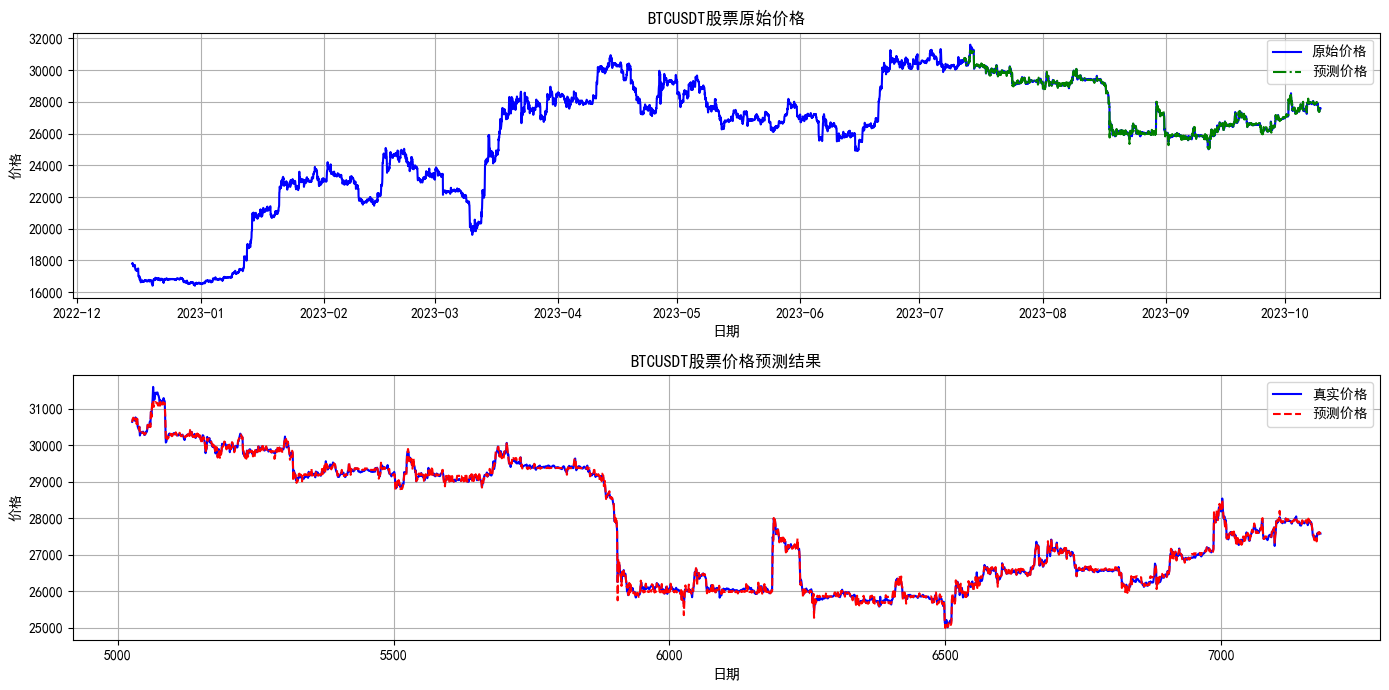

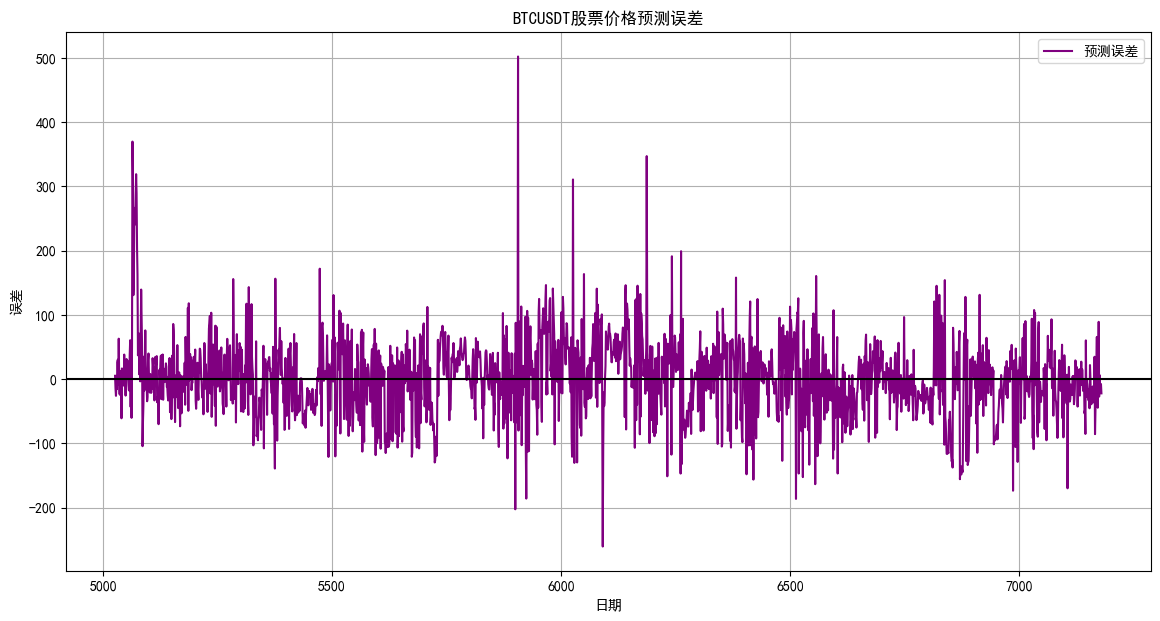

In [17]:
train_size = len(y_train)
visualize_results(df2, y_test, y_pred, 'BTCUSDT', train_size=train_size, dates=dates)